In [1]:
import pandas as pd

# Comparing Similarities of Strings

## Minimum edit distance 

Minimum edit distance is the <u>minimum number of operations</u> needed to reach from **String A** to **String B**, with the operations available being:

-	**Insertion** of a new character.

-	**Deletion** of an existing character.

-	**Substitution** of an existing character.

-	**Transposition** of two existing consecutive characters.

→ **The lower the edit distance, the closer two words are**

<img src="https://assets.datacamp.com/production/repositories/5737/datasets/30d7af9dea0c6111141548567263af9cfe4bc2ce/edit_distanceee.png" width=500 height=200>
<img src="https://assets.datacamp.com/production/repositories/5737/datasets/403caced07bc4752c320a8bb7bd24aad2b42a9ab/typo.png" width=550 height=200>

<br>

There's a variety of algorithms based on edit distance that differ on which operations they use, how much weight attributed to each operation, which type of strings they're suited for and more, with a variety of packages to get each similarity.

### Minimum edit distance algorithms

| Algorithm            | Operations                                      |
|----------------------|-------------------------------------------------|
| Damerau-Levenshtein  | insertion, substitution, deletion, transposition|
| Levenshtein          | insertion, substitution, deletion               |
| Hamming              | substitution only                               |
| Jaro distance        | transposition only                              |
| ...                  | ...                                             |

**Possible packages:** `nltk`, `thefuzz`, `textdistance`, ...

→ We'll use `Levenshtein` algo since it's the most general form of string matching by using the `thefuzz` package.

In [2]:
# `thefuzz` is a package to perform string comparison. `thefuzz` is a more recent fork of `fuzzywuzzy`. 
# It was created because the original `fuzzywuzzy` library had some issues with maintenance and compatibility, 
# especially with newer versions of Python. The thefuzz fork maintains compatibility with newer Python versions and continues to receive updates
from thefuzz import fuzz, process

# For any comparison function using thefuzz, our output is a score from 0 to 100 with 0 being not similar at all, 100 being an exact match.
# `WRatio` stands for Weighted Ratio
print(fuzz.WRatio("Mohamed", "Mohammad"))
print(fuzz.WRatio("mohamed", "MOHAMED"))

# The WRatio function is highly robust against partial string comparison with different orderings. 
# For example here we compare the strings "Houston Rockets" and "Rockets", and still receive a high similarity score. 
print(fuzz.WRatio("Houston Rockets", "Rockets"))

# The same can be said for the strings "Houston Rockets vs Los Angeles Lakers" and "Lakers vs Rockets", 
	# where the team names are only partial and they are differently ordered.
print(fuzz.WRatio("Houston Rockets vs Los Angeles Lakers", "Lakers vs Rockets"))

80
100
90
86


## Collapsing categories with string similarity

What if there are many typos in the `df['continent']` column, such as "eur", "europe", "EU", "Europe", "Europa", "Eropa", "Evropa", ...

It's not practical to use the `.replace()` method to map all of these unique values to "Europe". **String Similarity to the rescue!**

Here is an example of treating such a situation:

**Task:**

The `restaurants` dataset has been collected from many sources, where the `cuisine_type` column is riddled with typos, and should contain only `italian`, `american` and `asian` cuisine types. There are so many unique categories that remapping them manually isn't scalable, and it's best to use string similarity instead.

Before doing so, we want to establish the **cutoff point** for the similarity score using the `thefuzz.process.extract()` function by finding the similarity score of the most distant typo of each category.

```python
Code:

# Finding the cutoff point

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()
cuisine_types = ['asian', 'american', 'italian']

for cuisine_type in cuisine_types:
	print(f"{cuisine_type} matches:", process.extract(cuisine_type, unique_types, limit = len(unique_types)), '\n')

```

```py
Output:

asian matches: [('asian', 100), ('asiane', 91), ('asiann', 91), ('asiian', 91), ('asiaan', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('italiano', 72), ('italianne', 72), ('italiaan', 68), ('italiian', 68), ('itallian', 68), ('italian', 67), ('amurican', 62), ('american', 62), ('ameerican', 60), ('aamerican', 60), ('ameriican', 60), ('amerrican', 60), ('ameerrican', 60), ('ammereican', 60), ('americann', 57), ('americano', 57), ('ammericann', 54), ('americin', 51), ('amerycan', 51), ('america', 50), ('merican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('itali', 40)]

american matches: [('american', 100), ('americann', 94), ('americano', 94), ('ameerican', 94), ('aamerican', 94), ('ameriican', 94), ('amerrican', 94), ('america', 93), ('merican', 93), ('ammericann', 89), ('ameerrican', 89), ('ammereican', 89), ('amurican', 88), ('americen', 88), ('americin', 88), ('amerycan', 88), ('murican', 80), ('asian', 62), ('asiane', 57), ('asiann', 57), ('asiian', 57), ('asiaan', 57), ('italian', 53), ('asianne', 53), ('italiann', 50), ('italiano', 50), ('italiaan', 50), ('italiian', 50), ('itallian', 50), ('italianne', 47), ('asiat', 46), ('itali', 40), ('italien', 40)]

italian matches: [('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93), ('itallian', 93), ('italianne', 88), ('italien', 86), ('itali', 83), ('asian', 67), ('asiane', 62), ('asiann', 62), ('asiian', 62), ('asiaan', 62), ('asianne', 57), ('amurican', 53), ('american', 53), ('americann', 50), ('asiat', 50), ('americano', 50), ('ameerican', 50), ('aamerican', 50), ('ameriican', 50), ('amerrican', 50), ('ammericann', 47), ('ameerrican', 47), ('ammereican', 47), ('america', 43), ('merican', 43), ('murican', 43), ('americen', 40), ('americin', 40), ('amerycan', 40)]
```

<br>

**Decision:** 80 seems to be the most appropriate cutoff point

<br>

```python
Code:

# Now let's fix typos using string similarity technique
for cuisine_type in cuisine_types:
	matches = process.extract(cuisine_type, unique_types, limit=len(unique_types))

	for match in matches:
		# Check whether the similarity score is greater than or equal to 80
		if match[1] >= 80:
		# If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
			restaurants.loc[restaurants["cuisine_type"] == match[0], "cuisine_type"] = cuisine_type

print(restaurants["cuisine_type"].unique())

```

```python
Output:

['american' 'asian' 'italian']
```

<br>

**N.B.** However, we may need to use the `.replace()` method as there might be strings beyond our cutoff point

In [3]:
# We can also compare a string with an array of strings by using the `extract()` function from the `process` module from `thefuzz`. 

string = "Houston Rockets vs Los Angeles Lakers"
choices = pd.Series (['Rockets vs Lakers', 'Lakers vs Rockets', 'Houson vs Los Angeles', 'Heat vs Bulls'])

# `extract()` takes in a string, an array of strings, and the number of possible matches to return ranked from highest to lowest. 
# Its output is a list of tuples where each is formatted like: (closest match, similarity score, its index in the array)
process.extract(string, choices, limit=2)

[('Rockets vs Lakers', 86, 0), ('Lakers vs Rockets', 86, 1)]

## Record Linkage

**Record linkage** is the process of identifying and linking records from different data sources that refer to the same event or entity but may have slight differences in their names or other attributes. We use record linkage when failing to merge both DataFrames using regular SQL joins, like Full Outer Join, due to the non existence of a column that contains a unique identifier in both DataFrames, like `customer_id`. Instead of the regular joins, record linkage involves the fuzzy join technique which deals with joining records based on approximate string matching.

**Record Linkage Example:**

-	"Houston Rockets vs Chicago Bulls" (19:00) is linked with "NBA: Bulls vs Rockets" (9pm).

-	"Miami Heat vs Los Angeles Lakers" (19:00) is linked with "NBA: Heat vs Lakers" (7pm).

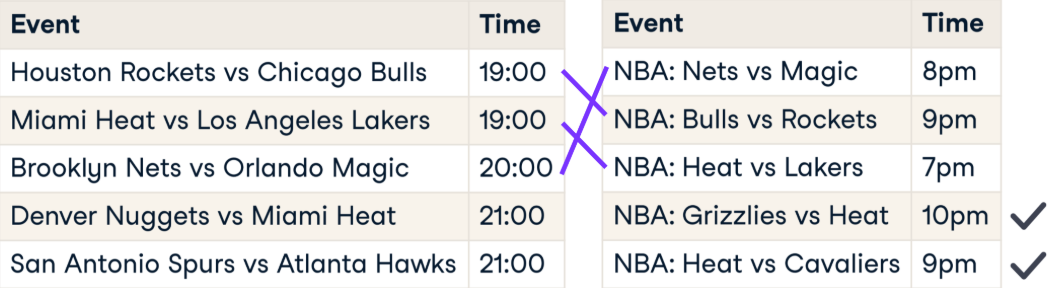

<br>

### Record Linkage Steps

<img src="https://assets.datacamp.com/production/repositories/5737/datasets/3b9dd9c1888f4384d9edc64ff97dfa808b6c553d/linkdata.png" width=750 height=300>

→ All of these steps can be achieved with the `recordlinkage` package

<br>

### Record Linking Procedures

1. **Generating Paris:** (with blocking if necessary and applicable)

We first want to generate pairs between both DataFrames. Ideally, we want to generate all possible pairs between our DataFrames. But, what if we had big DataFrames and ended up having to generate millions if not billions of pairs? It wouldn't be scalable and could seriously hamper development time.

<img src="https://assets.datacamp.com/production/repositories/5698/datasets/e1496092e695776f0636ab74357b769cdd4d23d6/reclin_pairs_2.png" width=750 height=300>

<br>

This is where we apply what we call **blocking**, which creates pairs based on a matching column, which is in this case, the `state` column, reducing the number of possible pairs.

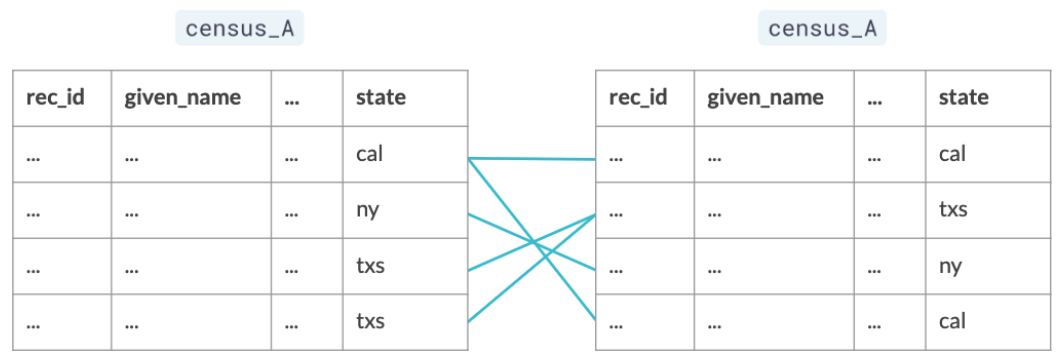

<br>

2. **Setting the Comparison Design** (exact matches OR string similarities with certain thresholds)

3. **Computing the `potential_matches` DataFrame**

4. **Filtering our `potential_matches` DataFrame** (filter for rows where the sum of row values is higher than a certain threshold)

5. **Remove these matching rows from either the 1st or the 2nd dataset** (so that when merging them there are no duplicates)

6. **Link the DataFrames!**

In [4]:
res1 = pd.read_csv("https://raw.githubusercontent.com/MohamedMostafa259/Pandas-Notes/refs/heads/main/Data/restaurants_L2_dirty.csv", index_col=0)
print(res1.head(), '\n')

res2 = pd.read_csv("https://raw.githubusercontent.com/MohamedMostafa259/Pandas-Notes/refs/heads/main/Data/restaurants_L2.csv", index_col=0)
res2.head()

# We want to merge them while avoiding duplication using record linkage since they are collected manually and are prone to typos, 
# and there are no consistent IDs between them.

      name                      addr         city       phone          type
0   kokomo         6333 w. third st.           la  2139330773      american
1   feenix   8358 sunset blvd. west     hollywood  2138486677      american
2  parkway      510 s. arroyo pkwy .     pasadena  8187951001   californian
3     r-23          923 e. third st.  los angeles  2136877178      japanese
4    gumbo         6333 w. third st.           la  2139330358  cajun/creole 



,name,addr,city,phone,type
0,arnie morton's of chicago,435 s. la cienega blv .,los angeles,3102461501,american
1,art's delicatessen,12224 ventura blvd.,studio city,8187621221,american
2,campanile,624 s. la brea ave.,los angeles,2139381447,american
3,fenix,8358 sunset blvd. west,hollywood,2138486677,american
4,grill on the alley,9560 dayton way,los angeles,3102760615,american


In [5]:
import recordlinkage

# create an Index object. This is an object we can use to generate pairs from our DataFrames.
indexer = recordlinkage.Index()

# To generate pairs blocked on a column, we use the `.block()` method, inputting the desired column. 
# Once the indexer object has been initialized, we generate our pairs using the `.index()` method, which takes in the two dataframes.
indexer.block("city")
pairs = indexer.index(res1, res2) # returns pandas.MultiIndex

# This MultiIndex object contains pairs of row indices from both DataFrames, 
# which is effectively an array containing possible pairs of indices that makes it much easier to subset DataFrames on
pairs 

MultiIndex([( 1,   3),
            ( 3,   0),
            ( 3,   2),
            ( 3,   4),
            ( 3,   5),
            ( 3,   6),
            ( 3,   8),
            ( 3,   9),
            ( 3,  10),
            ( 3,  12),
            ...
            (75,  98),
            (75, 100),
            (79,   7),
            (79,  61),
            (80,  11),
            (80,  63),
            (80,  68),
            (80,  71),
            (80,  83),
            (80,  90)],
           length=2047)

In [6]:
# it's time to find potential matches. Let's create a Compare object
# This object is responsible for assigning different comparison procedures for pairs.
compare = recordlinkage.Compare()

# Let's say there are columns for which we want exact matches between the pairs.
# `.exact()` takes in the column name in question for each DataFrame and a label argument which is the column name in the resulting DataFrame.
compare.exact("city", "city", label="city")
compare.exact("phone", "phone", label="phone")
compare.exact("type", "type", label="type")

# Now, let's compute string similarities between pairs of rows for columns that have fuzzy values
# `.string()` also takes in the column names in question, the similarity cutoff point in the `threshold` argument (from 0 to 1)
compare.string("name", "name", label="name", threshold=0.8)
compare.string("addr", "addr", label="addr", threshold=0.8)

# IMPORTANT: you need to always have the same order of DataFrames when inserting them as arguments when generating pairs, 
# IMPORTANT: comparing between columns, and computing comparisons.
potential_matches = compare.compute(pairs, res1, res2) 
potential_matches

# The output is a multi index DataFrame, where the first index is the row index from the 1st DataFrame, 
# and the second index is a list of all row indices in the 2nd DataFrame. 
# The columns are the columns being compared, with values being 1 for a match, and 0 for not a match.

city  phone  type  name  addr
1  3      1      1     1   1.0   1.0
3  0      1      0     0   0.0   0.0
   2      1      0     0   0.0   0.0
   4      1      0     0   0.0   0.0
   5      1      0     0   0.0   0.0
...     ...    ...   ...   ...   ...
80 63     1      0     0   0.0   0.0
   68     1      0     0   0.0   0.0
   71     1      0     0   0.0   0.0
   83     1      0     0   0.0   0.0
   90     1      0     0   0.0   0.0

[2047 rows x 5 columns]

In [7]:
# To find potential matches, we just filter for rows where the sum of row values is higher than a certain threshold.
# .sum(axis=1) → for row-wise summing
matches = potential_matches[potential_matches.sum(axis=1) >= 5]
matches

,,city,phone,type,name,addr
1,3,1,1,1,1.0,1.0
7,13,1,1,1,1.0,1.0
12,17,1,1,1,1.0,1.0
20,20,1,1,1,1.0,1.0
21,11,1,1,1,1.0,1.0
26,12,1,1,1,1.0,1.0
27,21,1,1,1,1.0,1.0
28,1,1,1,1,1.0,1.0
40,0,1,1,1,1.0,1.0
43,8,1,1,1,1.0,1.0


In [8]:
# Next, we want to remove these matching rows from either the 1st or the 2nd dataset so that when merging them there are no duplicates

# Here we choose the 2nd index column, which represents row indices of `res2`. 
# We want to extract those indices, and subset `res2` on them to remove duplicates with `res1` before appending them together.
# MultiIndex.get_level_values(index column's name | its order) → to extract an Index object from a MultiIndex object 
duplicate_indices_res2 = matches.index.get_level_values(1)
print(duplicate_indices_res2)

res2_new = res2[~res2.index.isin(duplicate_indices_res2)]

# `ignore_index=True` resets the index in the resulting DataFrame so that the index is continuous
full_res = pd.concat([res1, res2_new], ignore_index=True)
full_res

Index([3, 13, 17, 20, 11, 12, 21, 1, 0, 8, 19, 9, 4, 15, 16, 5, 14, 18, 6, 2,
       10, 7],
      dtype='int64')


,name,addr,city,phone,type
0,kokomo,6333 w. third st.,la,2139330773,american
1,feenix,8358 sunset blvd. west,hollywood,2138486677,american
2,parkway,510 s. arroyo pkwy .,pasadena,8187951001,californian
3,r-23,923 e. third st.,los angeles,2136877178,japanese
4,gumbo,6333 w. third st.,la,2139330358,cajun/creole
...,...,...,...,...,...
391,vivande porta via,2125 fillmore st.,san francisco,4153464430,italian
392,vivande ristorante,670 golden gate ave.,san francisco,4156739245,italian
393,world wrapps,2257 chestnut st.,san francisco,4155639727,american
394,wu kong,101 spear st.,san francisco,4159579300,asian
